# <font color = 'maroon'>K_Mnist_Deep_Neural_Network</font>



Student Name - Damith Senadeera

Please upload the d2l.py file to the colab run time and then import all the following libraries

In [1]:
import d2l
import numpy as np 
import pandas as pd 

import torch
from torch import nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms


## <font color = 'maroon'>Task 1 - Data Loader Definition</font>

The following cell defines the data loader function for the KMNIST data set for both training and testing sets with the option of seting a batch size and resizing the original images. The following function was adopted by referring to the "load_data_fashion_mnist" function in d2l library.

In [2]:
def load_data_k_mnist(batch_size, resize=None):
    """Download the KMNIST dataset and then load it into memory.

    Parameters  :batch_size: 'the batch size of the images to be outputed'

                :resize:  'the output size of an KMNIST image'
    """

    #apply the resize transformation for images
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    #download the standard KMNIST trianing set
    mnist_train = torchvision.datasets.KMNIST(
        root="data", train=True, transform=trans, download=True)
    
    #download the standard KMNIST validation(testing) set
    mnist_test = torchvision.datasets.KMNIST(
        root="data", train=False, transform=trans, download=True)
    
    #return the transformed dataset with the given batch size
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

## <font color = 'maroon'>Task 2 - Model Definition</font>

### <font color = 'maroon'>Part 1 - Stem Block Definition</font>

The below cell defines the stem block of the network where feature extraction is done.

In [3]:
class NetStem(nn.Module):
    def __init__(self, no_p, ptch_sz_tot, ptch_sz, no_d):
        super(NetStem, self).__init__()
        
        self.ptch_sz_tot = ptch_sz_tot #total size of an extracted patch (k*k)
        self.no_d = no_d #the new no. of dimensions the total patch size is mapped into
        self.no_p = no_p #no. of patches produced according to the given patch size
        
        #the unfold function produces a list of patches from an image where kernal size is the size of a patch
        self.add_module('unfold', nn.Unfold(kernel_size=(ptch_sz, ptch_sz), stride=ptch_sz)) 
        #here stride euqals to the patch_size as we want non-overlapping patches from the unfold function

        #initialize linear layer to transform total patch size into uder defined defined d dimension(no_d)
        self.add_module('stem_lin1', nn.Linear(ptch_sz_tot, no_d))


        self.add_module('batchnorm_ft', nn.BatchNorm1d(self.no_p))
        self.add_module('relu_ft', nn.ReLU())
        
        
    def forward(self, x):
        
        out = self._modules['unfold'](x) # divide the image into non-overlapping patches
        # the output comes in the dimensions (batch_size * ptch_sz_tot * no_p)

        out = out.transpose(1,2)
        #here we are reshaping the output to have dimensions (batch_size * no_p * ptch_sz_tot)
        #as we need to have the ptch_sz_tot as the last dimension to map that into no_d

        out = self._modules['stem_lin1'](out)
        #all the extracted patches of size k*k are mapped into no_d 
        
        #additional batch normalization to accelerate the network convergence
        out = self._modules['batchnorm_ft'](out)
        out = self._modules['relu_ft'](out)

        #the output will be of the dimensions (batch_size * no_p * no_d)
        
        return out

### <font color = 'maroon'>Part 2 - Backbone Block Definition</font>

The below cell defines a backbone block of the network where MLPs are learning the best representations of the extracted features.

In [4]:

class NetBackboneAdvanced(nn.Module):
    def __init__(self, no_p, no_d, hidden1, hidden2):
        super(NetBackboneAdvanced, self).__init__()

        self.no_d = no_d #the new no. of dimensions the total patch size is mapped into
        self.no_p = no_p #no. of patches produced according to the given patch size
        
        #linear layer initialization to convert no_p to hidden dimension 1
        self.add_module('back_lin1', nn.Linear(no_p, hidden1))

        self.add_module('batchnorm1', nn.BatchNorm1d(no_d))
        self.add_module('relu1', nn.ReLU())

        #linear layer initialization to convert hidden dimension 1 back to no_p 
        self.add_module('back_lin2', nn.Linear(hidden1,no_p)) 
        
         #linear layer initialization to convert no_d to hidden dimension 2
        self.add_module('back_lin3', nn.Linear(no_d, hidden2))

        self.add_module('batchnorm2', nn.BatchNorm1d(no_p))
        self.add_module('relu2', nn.ReLU())

        #linear layer initialization to convert hidden dimension 2 back to no_d
        self.add_module('back_lin4', nn.Linear(hidden2, no_d))

        self.add_module('relu3', nn.ReLU())
        
            
        
    def forward(self, x):
        #the input will be of the dimensions (batch_size * no_p * no_d)
        out = x
        
        #trnaspose is taken to make the no. of patches(no_p) as the final dimension to the linear layer input keeping the batch size the same
        out = out.transpose(1,2) #the intermediate output will be of the dimensions (batch_size * no_d * no_p)

        # MLP 1 to learn the hidden dimenssions for the number of patches(no_p)
        out = self._modules['back_lin1'](out) 

        #additional batch normalization is added to accelerate the convergence
        out = self._modules['batchnorm1'](out)

        #non-linear activation function
        out = self._modules['relu1'](out)

        #converting back the number of of patches(no_p) from hideen dimensions
        out = self._modules['back_lin2'](out)
        #the intermediate output will be of the dimensions (batch_size * no_d * no_p)


        
        #trnaspose is taken to make the transformed dimensions d(no_d) as the final dimension of the linear layer keeping the batch size the same
        out = out.transpose(1,2)#the intermediate output will be of the dimensions (batch_size * no_p * no_d)

        # MLP 2 to learn the hidden dimenssions for the transformed dimensions d(no_d)
        out = self._modules['back_lin3'](out) 

        #additional batch normalization is added to accelerate the convergence
        out = self._modules['batchnorm2'](out)

        #non-linear activation function
        out = self._modules['relu2'](out)

        #converting back the transformed dimensions d(no_d) from hideen dimensions
        out = self._modules['back_lin4'](out)
        #the intermediate output will be of the dimensions (batch_size * no_p * no_d)

        
        #skip connection to alleviate the degradation problem when adding more blocks
        out = out + x
        out = self._modules['relu3'](out)

        #the output will be of the dimensions same as of the stem block which is (batch_size * no_p * no_d)
        
        return out  

        

### <font color = 'maroon'>Part 3 - Classfier Block Definition</font>

The below cell defines the classifier block of the network where the output of the backbone block is classfied into the respective classes.

In [5]:

class Classifier(nn.Module):
    def __init__(self, no_d):
        super(Classifier, self).__init__()

        self.no_d = no_d #the new no. of dimensions the total patch size is mapped into
        

        self.add_module('classifier1', nn.Sequential(nn.Flatten(), nn.Linear(no_d, no_d), nn.ReLU(), nn.Dropout(0.5), nn.Linear(no_d, no_d), nn.ReLU(),nn.Dropout(0.5),  nn.Linear(no_d, 10)))
        #classification layer with 3 linear layers with ReLU activations and drop-out regularization
            
        
    def forward(self, x):
        out = x

        out = torch.mean(out, dim=1) 
        #taking the mean over all the no. of patches(no_p) produced

        out = self._modules['classifier1'](out)  
       
        
        return out  

        

### <font color = 'maroon'>Part 4 - Network Definition</font>

The below cell defines the neural network stacking the stem and multiple backbone cells along with the final classification layer.

In [6]:
class NetModel(nn.Module):
    def __init__(self, in_channels=1, inp_size=32, no_d=512, ptch_sz=8, backbone_hidden_dims = [(128, 256), (256, 512)]):
        super(NetModel, self).__init__()
        
        self.ptch_sz = ptch_sz # patch size of an image (k)
        self.ptch_sz_tot = int(ptch_sz*ptch_sz) #total size of an extracted patch (k*k)
        self.no_p = int(((inp_size*inp_size)/self.ptch_sz_tot)*in_channels) #no. of patches produced according to the given patch size
        self.no_d = no_d #the new no. of dimensions the total patch size is mapped into
        self.backbone_len = len(backbone_hidden_dims) #no. of backbone blocks to be added to the network
        
        self.add_module('stem1', NetStem(self.no_p, self.ptch_sz_tot, ptch_sz, no_d))
        #one stem block is added to extract features

        #backbone blocks are added according to the user defined number of blocks 
        for i, (hidden1, hidden2) in enumerate(backbone_hidden_dims):
            
            #the hidden dimension numbers for backbone blocks are taken from the user-defined list
            self.add_module('backbone{0}'.format(i),NetBackboneAdvanced(self.no_p, no_d, hidden1, hidden2))
                            
        self.add_module('classifier_layer', Classifier(no_d))
        #defining the classifier block for the output of the final backbone block
        
        
    def forward(self, x):
        out = x

        #the initial batch of images are fed into stem to extract the features
        out = self._modules['stem1'](out)
        
        #then the batch of extracted features are fed into the initial backbone block and the output
        #of each backbone cell is fed in to the consequent backbone blocks
        for i in range(self.backbone_len):
            out = self._modules['backbone{0}'.format(i)](out)

        #the output of the final backbone block is fed into the classifier block                                       
        out = self._modules['classifier_layer'](out)   

        #print(out.shape)                 
                            
        
        return out

## <font color = 'maroon'>Task 3 - Loss and Optimiser Definition</font>

In the following cell the loss and optimizer functions are defined, specially the optimizer might be changed in the experiments done afterwards as I will experiment with different optimisers (as a hyper-parameter) to find the best result.

In [7]:
lr, num_epochs, batch_size = 0.001, 10, 128

loss = nn.CrossEntropyLoss() #cross entropy loss function to update weights

hidden_dims = [(64, 64)]#defining only 1 backbone block

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=64, ptch_sz=2, backbone_hidden_dims = hidden_dims)

optimizer = torch.optim.Adam(modelnet2.parameters(), lr=lr, weight_decay=0.0001)
#weight update mechanism - Initially Adam optimizer is used, but later on SGD is used with a higher number of epochs for the final model.

## <font color = 'maroon'>Task 4 - Training Function Definition and Conducting Experiments</font>

### <font color = 'maroon'>Part 1 - Training Function Definition</font>

In the below cell the function to train the constructed model with hyper-parameters is defined. This function trains the model according to the given hyper parameters, plot the curves for training loss, training accuracy and testing accuracy and returns a dataframe with the train metrics for each epoch.

In [8]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device, scheduler=None, ylim=(None, (0, 1))):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=ylim,
                        legend=[['train loss'], ['train acc', 'test acc']],
                        ncols=2, figsize=(7, 2.5)) #initialize the loss, accuracy diagram updater
    
    metric_dict = {}

    column_names=["Epoch", "Training Loss", "Training Accuracy", "Testing Accuracy"]
    
    metric_df =  pd.DataFrame([[0,0,0,0]], columns=column_names)
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train() #sets the network into training mode
            optimizer.zero_grad() #clear all the previous gradient to zero
            X, y = X.to(device), y.to(device) 
            y_hat = net(X) #compute the prediction and related weights
            l = loss(y_hat, y) #compute the loss by comparing real and predicted lables
            l.backward() #gradients are computed for the backward pass with respect to the loss
            optimizer.step() #graidents are propagated backwards and the network weights are updated accordingly
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
                #the training loss and the training accuracies are accumilated

            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            
        #if a scheduler for the learning rate is defined, reduce the learning rate accordingly
        if scheduler:
            scheduler.step()

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        #at the end of each epoch testing accuracy is computed here puting the network
        #into evaluation mode

        metric_dict[("Epoch "+str(epoch))] = 'training loss : '+str(round(train_loss, 5))+' ,train acc : '+str(round(train_acc, 5))+' ,test acc : '+str(round(test_acc, 5))
        new_row = {"Epoch":epoch+1, "Training Loss":train_loss, "Training Accuracy":train_acc , "Testing Accuracy":test_acc}
        metric_df = metric_df.append(new_row, ignore_index=True)
        print(f'training loss {train_loss:.5f}, train acc {train_acc:.5f}, 'f'test acc {test_acc:.5f}'+'\n')
        animator.add(epoch + 1, [train_loss, (train_acc, test_acc)])
        
    
    for each in metric_dict:
      print(each + " "+metric_dict[each] )

    print("")
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')
    print("")

    metric_df = metric_df.drop([0])

    return metric_df

### <font color = 'maroon'>Part 2 - Conducting Experiments</font>

#### <font color = 'maroon'>Experiment 1</font>

Below cell defines the model with respective hyper-parameters for experiment 1

In [18]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64)] #defining only 1 backbone block with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=128, ptch_sz=2, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.001, 10, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(2, 2), dilation=1, padding=0, stride=2)
    (stem_lin1): Linear(in_features=4, out_features=128, bias=True)
    (batchnorm_ft): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=256, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=256, bias=True)
    (back_lin3): Linear(in_features=128, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=128, bias=True)
    (relu3): ReLU()
  )
  (classifier_layer): Classifier(
    (classifier1): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Below cell shows how the model was trained and the training loss, training accuracy and testing accuracy attained at the end of each epoch along with the curves of these metrics.

Epoch 0 training loss : 1.36045 ,train acc : 0.46303 ,test acc : 0.6024
Epoch 1 training loss : 0.66999 ,train acc : 0.79295 ,test acc : 0.7084
Epoch 2 training loss : 0.48507 ,train acc : 0.85993 ,test acc : 0.7622
Epoch 3 training loss : 0.40581 ,train acc : 0.88365 ,test acc : 0.7734
Epoch 4 training loss : 0.34296 ,train acc : 0.9018 ,test acc : 0.7966
Epoch 5 training loss : 0.30662 ,train acc : 0.91403 ,test acc : 0.8098
Epoch 6 training loss : 0.27325 ,train acc : 0.92107 ,test acc : 0.8339
Epoch 7 training loss : 0.2471 ,train acc : 0.9298 ,test acc : 0.8411
Epoch 8 training loss : 0.2308 ,train acc : 0.93492 ,test acc : 0.8399
Epoch 9 training loss : 0.21563 ,train acc : 0.93933 ,test acc : 0.8264

10295.9 examples/sec on cuda



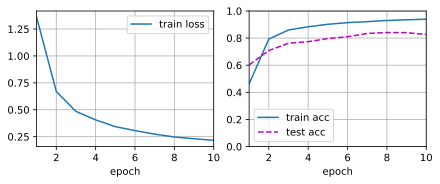

In [19]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer,device)

#### <font color = 'maroon'>Experiment 2</font>

Below cell defines the model with respective hyper-parameters for experiment 2

In [12]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64)] #defining only 1 backbone block with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=128, ptch_sz=4, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.001, 10, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=4)
    (stem_lin1): Linear(in_features=16, out_features=128, bias=True)
    (batchnorm_ft): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=64, bias=True)
    (back_lin3): Linear(in_features=128, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=128, bias=True)
    (relu3): ReLU()
  )
  (classifier_layer): Classifier(
    (classifier1): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Below cell shows how the model was trained and the training loss, training accuracy and testing accuracy attained at the end of each epoch along with the curves of these metrics for experiment 2.

Epoch 0 training loss : 1.44099 ,train acc : 0.43245 ,test acc : 0.5362
Epoch 1 training loss : 0.78453 ,train acc : 0.73315 ,test acc : 0.6852
Epoch 2 training loss : 0.52237 ,train acc : 0.8422 ,test acc : 0.7463
Epoch 3 training loss : 0.40132 ,train acc : 0.88438 ,test acc : 0.7872
Epoch 4 training loss : 0.32832 ,train acc : 0.90632 ,test acc : 0.8036
Epoch 5 training loss : 0.29101 ,train acc : 0.91717 ,test acc : 0.8192
Epoch 6 training loss : 0.26069 ,train acc : 0.92578 ,test acc : 0.8342
Epoch 7 training loss : 0.24487 ,train acc : 0.93052 ,test acc : 0.8516
Epoch 8 training loss : 0.2242 ,train acc : 0.9373 ,test acc : 0.8466
Epoch 9 training loss : 0.20785 ,train acc : 0.94035 ,test acc : 0.8505

10387.0 examples/sec on cuda



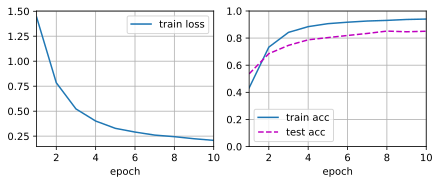

In [13]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer,device)

#### <font color = 'maroon'>Experiment 3</font>

Below cell defines the model with respective hyper-parameters for experiment 3

In [49]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64)] #defining only 1 backbone block with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=128, ptch_sz=8, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.001, 10, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(8, 8), dilation=1, padding=0, stride=8)
    (stem_lin1): Linear(in_features=64, out_features=128, bias=True)
    (batchnorm_ft): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=16, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=16, bias=True)
    (back_lin3): Linear(in_features=128, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=128, bias=True)
    (relu3): ReLU()
  )
  (classifier_layer): Classifier(
    (classifier1): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Below cell shows how the model was trained and the training loss, training accuracy and testing accuracy attained at the end of each epoch along with the curves of these metrics for experiment 3.

Epoch 0 training loss : 1.36307 ,train acc : 0.5078 ,test acc : 0.6035
Epoch 1 training loss : 0.62232 ,train acc : 0.8122 ,test acc : 0.7256
Epoch 2 training loss : 0.44714 ,train acc : 0.86885 ,test acc : 0.7612
Epoch 3 training loss : 0.36858 ,train acc : 0.8926 ,test acc : 0.7921
Epoch 4 training loss : 0.32049 ,train acc : 0.90808 ,test acc : 0.8078
Epoch 5 training loss : 0.29206 ,train acc : 0.91572 ,test acc : 0.8213
Epoch 6 training loss : 0.264 ,train acc : 0.92402 ,test acc : 0.8379
Epoch 7 training loss : 0.24147 ,train acc : 0.93072 ,test acc : 0.831
Epoch 8 training loss : 0.22362 ,train acc : 0.93547 ,test acc : 0.8397
Epoch 9 training loss : 0.21177 ,train acc : 0.93883 ,test acc : 0.8486

10268.6 examples/sec on cuda



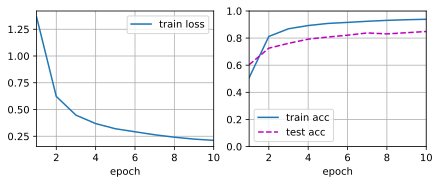

In [50]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer,device)

#### <font color = 'maroon'>Experiment 4</font>

Below cell defines the model with respective hyper-parameters for experiment 4

In [46]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64),(128, 128),(256, 256)] #defining 3 backbone blocks with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=256, ptch_sz=4, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.001, 10, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=4)
    (stem_lin1): Linear(in_features=16, out_features=256, bias=True)
    (batchnorm_ft): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=64, bias=True)
    (back_lin3): Linear(in_features=256, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=256, bias=True)
    (relu3): ReLU()
  )
  (backbone1): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=128, bias=True)
    (batchnorm1): BatchNo

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Below cell shows how the model was trained and the training loss, training accuracy and testing accuracy attained at the end of each epoch along with the curves of these metrics for experiment 4.

Epoch 0 training loss : 0.79084 ,train acc : 0.73315 ,test acc : 0.8091
Epoch 1 training loss : 0.26332 ,train acc : 0.9256 ,test acc : 0.8586
Epoch 2 training loss : 0.17854 ,train acc : 0.95133 ,test acc : 0.8809
Epoch 3 training loss : 0.14308 ,train acc : 0.9609 ,test acc : 0.8995
Epoch 4 training loss : 0.11684 ,train acc : 0.96827 ,test acc : 0.8975
Epoch 5 training loss : 0.10022 ,train acc : 0.97318 ,test acc : 0.9074
Epoch 6 training loss : 0.08657 ,train acc : 0.9762 ,test acc : 0.9143
Epoch 7 training loss : 0.08409 ,train acc : 0.97738 ,test acc : 0.9233
Epoch 8 training loss : 0.07057 ,train acc : 0.98062 ,test acc : 0.9139
Epoch 9 training loss : 0.06434 ,train acc : 0.9825 ,test acc : 0.9258

6551.1 examples/sec on cuda



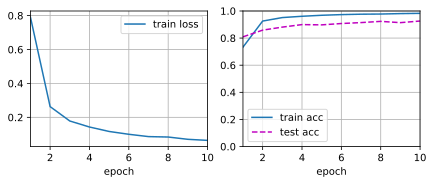

In [47]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer,device)

#### <font color = 'maroon'>Experiment 5</font>

Below cell defines the model with respective hyper-parameters for experiment 5

In [53]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64),(128, 128),(256, 256)] #defining 3 backbone blocks with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=256, ptch_sz=8, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.001, 10, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(8, 8), dilation=1, padding=0, stride=8)
    (stem_lin1): Linear(in_features=64, out_features=256, bias=True)
    (batchnorm_ft): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=16, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=16, bias=True)
    (back_lin3): Linear(in_features=256, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=256, bias=True)
    (relu3): ReLU()
  )
  (backbone1): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=16, out_features=128, bias=True)
    (batchnorm1): BatchNo

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Below cell shows how the model was trained and the training loss, training accuracy and testing accuracy attained at the end of each epoch along with the curves of these metrics for experiment 5.

Epoch 0 training loss : 0.75585 ,train acc : 0.74535 ,test acc : 0.8273
Epoch 1 training loss : 0.24207 ,train acc : 0.934 ,test acc : 0.872
Epoch 2 training loss : 0.17433 ,train acc : 0.95187 ,test acc : 0.8811
Epoch 3 training loss : 0.13968 ,train acc : 0.96165 ,test acc : 0.8991
Epoch 4 training loss : 0.1117 ,train acc : 0.96932 ,test acc : 0.8991
Epoch 5 training loss : 0.09763 ,train acc : 0.97262 ,test acc : 0.907
Epoch 6 training loss : 0.08582 ,train acc : 0.97518 ,test acc : 0.9136
Epoch 7 training loss : 0.07531 ,train acc : 0.97902 ,test acc : 0.9148
Epoch 8 training loss : 0.06622 ,train acc : 0.98155 ,test acc : 0.9043
Epoch 9 training loss : 0.06118 ,train acc : 0.98302 ,test acc : 0.9074

6568.4 examples/sec on cuda



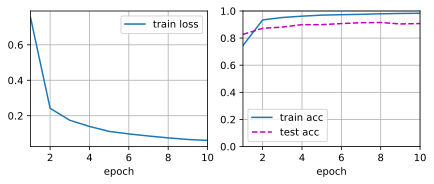

In [54]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer,device)

## <font color = 'maroon'>Task 5 - Final Model results with best testing accuracy obtained</font>

Finally I chose patch size (ptch_sz) as 4 because in all the 5 experiments above best testing accyracy was reached when ptch_sz=4. Since it was evident that when the number of Backbone blocks increassed the accuracy also increased, I defined the final model with 6 Backbone blocks with 719,626 trainable parameters in the network.

The same final model is initialiazed and trained 3 times seperately with the same set of hyper-parameters to get the final testing accuracy and to check if the stability of the model

### <font color = 'maroon'>Final Model - Run no. 1 </font>

In [32]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64),(64, 64), (128, 128), (128, 128), (256, 256), (256, 256)] #defining 6 backbone blocks with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=256, ptch_sz=4, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.05, 50, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

#learning rate scheduler which decreases the lr by 30% after 20 epochs each
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=4)
    (stem_lin1): Linear(in_features=16, out_features=256, bias=True)
    (batchnorm_ft): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=64, bias=True)
    (back_lin3): Linear(in_features=256, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=256, bias=True)
    (relu3): ReLU()
  )
  (backbone1): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNor

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 training loss : 2.10955 ,train acc : 0.18973 ,test acc : 0.297
Epoch 1 training loss : 0.84548 ,train acc : 0.70552 ,test acc : 0.7193
Epoch 2 training loss : 0.32113 ,train acc : 0.90938 ,test acc : 0.8343
Epoch 3 training loss : 0.20532 ,train acc : 0.94243 ,test acc : 0.8583
Epoch 4 training loss : 0.15096 ,train acc : 0.95792 ,test acc : 0.8858
Epoch 5 training loss : 0.11781 ,train acc : 0.9676 ,test acc : 0.8953
Epoch 6 training loss : 0.09837 ,train acc : 0.97235 ,test acc : 0.9044
Epoch 7 training loss : 0.07511 ,train acc : 0.9787 ,test acc : 0.9119
Epoch 8 training loss : 0.06554 ,train acc : 0.98212 ,test acc : 0.9087
Epoch 9 training loss : 0.05893 ,train acc : 0.98367 ,test acc : 0.9111
Epoch 10 training loss : 0.04777 ,train acc : 0.98613 ,test acc : 0.914
Epoch 11 training loss : 0.04668 ,train acc : 0.98668 ,test acc : 0.9051
Epoch 12 training loss : 0.03815 ,train acc : 0.98947 ,test acc : 0.9172
Epoch 13 training loss : 0.03569 ,train acc : 0.98987 ,test acc :

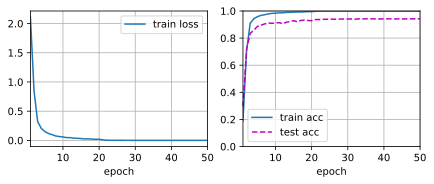

In [33]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer, device, scheduler)

### <font color = 'maroon'>Final Model - Run no. 2 </font>

In [9]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64),(64, 64), (128, 128), (128, 128), (256, 256), (256, 256)] #defining 6 backbone blocks with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=256, ptch_sz=4, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.05, 50, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

#learning rate scheduler which decreases the lr by 30% after 20 epochs each
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=4)
    (stem_lin1): Linear(in_features=16, out_features=256, bias=True)
    (batchnorm_ft): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=64, bias=True)
    (back_lin3): Linear(in_features=256, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=256, bias=True)
    (relu3): ReLU()
  )
  (backbone1): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNor

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 training loss : 2.09825 ,train acc : 0.19067 ,test acc : 0.3208
Epoch 1 training loss : 0.91352 ,train acc : 0.67618 ,test acc : 0.7766
Epoch 2 training loss : 0.32109 ,train acc : 0.91125 ,test acc : 0.8534
Epoch 3 training loss : 0.19793 ,train acc : 0.94548 ,test acc : 0.8799
Epoch 4 training loss : 0.14459 ,train acc : 0.96043 ,test acc : 0.8889
Epoch 5 training loss : 0.11124 ,train acc : 0.96918 ,test acc : 0.8957
Epoch 6 training loss : 0.09136 ,train acc : 0.975 ,test acc : 0.9106
Epoch 7 training loss : 0.07487 ,train acc : 0.97887 ,test acc : 0.8819
Epoch 8 training loss : 0.06123 ,train acc : 0.98207 ,test acc : 0.9217
Epoch 9 training loss : 0.05032 ,train acc : 0.98588 ,test acc : 0.9231
Epoch 10 training loss : 0.04548 ,train acc : 0.98752 ,test acc : 0.9235
Epoch 11 training loss : 0.03666 ,train acc : 0.98968 ,test acc : 0.9191
Epoch 12 training loss : 0.03085 ,train acc : 0.99108 ,test acc : 0.9195
Epoch 13 training loss : 0.03346 ,train acc : 0.99037 ,test acc

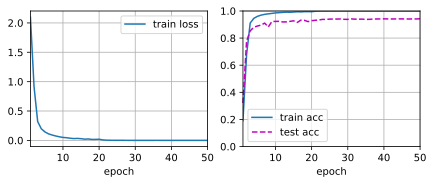

In [10]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer, device, scheduler)

### <font color = 'maroon'>Final Model - Run no. 3 </font>

In [11]:
#initializing the model and hyper parameters

hidden_dims = [(64, 64),(64, 64), (128, 128), (128, 128), (256, 256), (256, 256)] #defining 6 backbone blocks with hidden dimensions

modelnet2 = NetModel(in_channels=1, inp_size=32, no_d=256, ptch_sz=4, backbone_hidden_dims = hidden_dims)

print(modelnet2)
print("\nNo of trainable parameters = ",sum(p.numel() for p in modelnet2.parameters() if p.requires_grad), "\n")

lr, num_epochs, batch_size = 0.05, 50, 128
train_iter, test_iter = load_data_k_mnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelnet2.parameters(), lr=lr, weight_decay=0.0001)

#learning rate scheduler which decreases the lr by 30% after 20 epochs each
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

NetModel(
  (stem1): NetStem(
    (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=4)
    (stem_lin1): Linear(in_features=16, out_features=256, bias=True)
    (batchnorm_ft): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_ft): ReLU()
  )
  (backbone0): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (back_lin2): Linear(in_features=64, out_features=64, bias=True)
    (back_lin3): Linear(in_features=256, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (back_lin4): Linear(in_features=64, out_features=256, bias=True)
    (relu3): ReLU()
  )
  (backbone1): NetBackboneAdvanced(
    (back_lin1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNor

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0 training loss : 2.06578 ,train acc : 0.1966 ,test acc : 0.3156
Epoch 1 training loss : 0.79103 ,train acc : 0.7369 ,test acc : 0.788
Epoch 2 training loss : 0.30887 ,train acc : 0.91387 ,test acc : 0.8387
Epoch 3 training loss : 0.19949 ,train acc : 0.9457 ,test acc : 0.8724
Epoch 4 training loss : 0.14758 ,train acc : 0.95857 ,test acc : 0.8924
Epoch 5 training loss : 0.11731 ,train acc : 0.96733 ,test acc : 0.8967
Epoch 6 training loss : 0.08888 ,train acc : 0.97488 ,test acc : 0.9065
Epoch 7 training loss : 0.0758 ,train acc : 0.97845 ,test acc : 0.9141
Epoch 8 training loss : 0.06638 ,train acc : 0.98163 ,test acc : 0.9077
Epoch 9 training loss : 0.05378 ,train acc : 0.98507 ,test acc : 0.9158
Epoch 10 training loss : 0.04693 ,train acc : 0.98687 ,test acc : 0.9134
Epoch 11 training loss : 0.03825 ,train acc : 0.98902 ,test acc : 0.9155
Epoch 12 training loss : 0.03952 ,train acc : 0.98917 ,test acc : 0.9234
Epoch 13 training loss : 0.03187 ,train acc : 0.99098 ,test acc : 

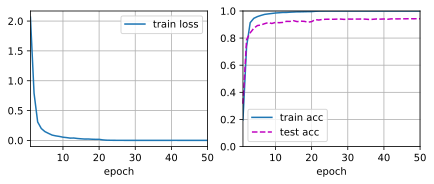

In [12]:
#traning the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
data_df = trainf(modelnet2, train_iter, test_iter, loss, num_epochs, optimizer, device, scheduler)